(512, 3)
(512,)
(3,)


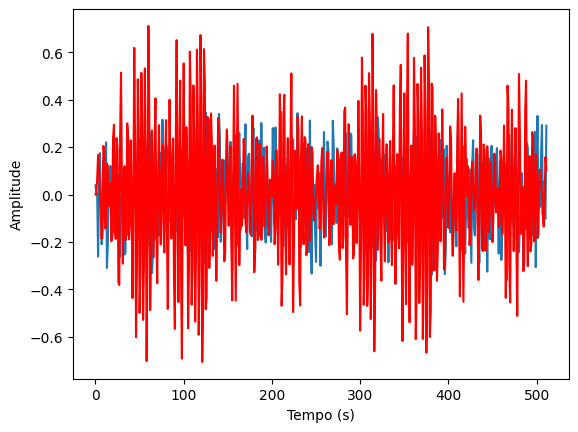

0.10637013012808086
-0.3082551881453568
Estimated Parameters:
a1 = -0.40500794522139427, a2 = 0.09827889771271578, b1 = 0.024286056095488326


In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
import pandas as pd
from sklearn.metrics import r2_score
from sysidentpy.metrics import mean_squared_error

# Load the 'robot_arm.dat' file, assuming it's tab-separated
# Load a dataset of a simulated dynamical system
file_path = 'robot_arm.dat'
try:
    robot_data = pd.read_csv(file_path, delimiter='\t')

except FileNotFoundError:
    print(f"File '{file_path}' not found.")
except Exception as e:
    print(f"An error occurred: {e}")


# Parameters
k1 = 1
k2 = 1
Ts = 2  # Sampling time
sgn = robot_data
cont = sgn.shape

# Extract columns from data
ra1 = robot_data.iloc[:, 0]
ra2 = robot_data.iloc[:, 1]

# Downsample the signals
rp = []  # Downsampled ra1
ent = []  # Downsampled ra2

for i in range(cont[0]):
    if (i % Ts) == 0:
        rp.append(ra1[i])

for i in range(cont[0]):
    if (i % Ts) == 0:
        ent.append(ra2[i])

rp = np.array(rp)
ent = np.array(ent)

# Define yr and ur (control signal)
Ta = Ts  # Sample time
yr = rp
cont_rp = rp.shape
ur = ent  # Control signal

# Create Y and fi matrices for least squares
Y = []
fi = []

for i in range(cont_rp[0]):
    if i < 2:
        y1 = 0
        y2 = 0
        u1 = 0
        u2 = 0
    else:
        y1 = yr[i-1]
        y2 = yr[i-2]
        u1 = ur[i-1]
        u2 = ur[i-2]
    
    y1 = float(y1)
    y2 = float(y2)
    u1 = float(u1)
    u2 = float(u2)

    yr2 = yr[i] - u1
    Y.append(yr2)
    fi.append([-y1, -y2, u2])

fi_np = np.array(fi) # Convert fi list to a NumPy array
Y_np = np.array(Y)

print(fi_np.shape)
print(Y_np.shape)


# Estimate parameters using Least Squares
teta = np.linalg.inv(fi_np.T @ fi_np) @ fi_np.T @ Y_np
print(teta.shape)
a1 = teta[0]
a2 = teta[1]
b1 = teta[2]

# Estimate the output (yest) using identified parameters
yest = np.zeros_like(yr)

for t in range(cont_rp[0]):
    if t < 2:
        yest[t] = 0
    else:
        yest[t] = -a1 * yest[t-1] - a2 * yest[t-2] + b1 * ur[t-2] + ur[t-1]

# Create the transfer function and convert to continuous time
Lz = signal.TransferFunction([1, b1], [1, a1, a2], dt=Ta)
Ls = Lz.to_tf()

# Plot results
tp = np.arange(0, cont_rp[0])
plt.plot(tp, yr, label="Plant_Real")
plt.plot(tp, yest, 'r', label="Plant_SI")

plt.xlabel('Tempo (s)')
plt.ylabel('Amplitude')
plt.show()

# Calculate estimation error
rrse = mean_squared_error(yest, yr)
print(rrse)
r2 = r2_score(yest,yr)
print(r2)

print("Estimated Parameters:")
print(f"a1 = {a1}, a2 = {a2}, b1 = {b1}")
